In [1]:
import h5py

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mplc
import scipy.stats as stats
import scipy
import seaborn as sns
import pandas as pd

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV

In [2]:
def spe_sen(y_pred, y_test):
    CM = confusion_matrix(y_pred, y_test)
    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    SEN = TP/(TP+FN)
    SPE = TN/(TN+FP)
    return SPE,SEN

In [3]:
def h5read(fn, idx):
    file=h5py.File(fn, 'r') 
    with file:
        dat = file[idx]
        return dat[:]

# dimred = KernelPCA(kernel="poly")
dimred = PCA(n_components = 0.9999)
# lenc = OneHotEncoder()
# X_ = h5read("../Jthing/out/isc|res_x.h5", "data")
# y_ = h5read("../Jthing/out/isc|res_y.h5", "data")
# X_ = h5read("../Jthing/out/rnd|res_x.h5", "data")
# y_ = h5read("../Jthing/out/rnd|res_y.h5", "data")
# X_ = h5read("../Jthing/out/ttest|res_x.h5", "data")
# y_ = h5read("../Jthing/out/ttest|res_y.h5", "data")
X_ = h5read("../Jthing/out/tstat_all|res_x.h5", "data")
y_ = h5read("../Jthing/out/tstat_all|res_y.h5", "data")

In [4]:
# lenc = LabelEncoder()
# y2 = fit_transform!(lenc, y_)
y2 = list(map( lambda x: x[0]=='V', y_))
# y2 = y_

combined_features = FeatureUnion([("pca", PCA(n_components = 600)), ("univ_select", SelectKBest(k = 30))])
pip = Pipeline([("features", combined_features),("scale",MinMaxScaler()),("svc", SVC(C=4000, probability=1))])
# top = GridSearchCV(estimator =pip, n_jobs = 1, param_grid =  {"svc__C":[4000]})
top = pip


# X_train, X_test, y_train, y_test = train_test_split(X_, y2, test_size=.2)
# top.fit(X_train, y_train)
# scor = top.score(X_test, y_test)

scor = 0.
for i in range(20):
    X_train, X_test, y_train, y_test = train_test_split(X_, y2, test_size=.2)
    top.fit(X_train, y_train)
    scor += top.score(X_test, y_test)
scor /= 20

y_pred = top.predict(X_test)
print(classification_report(y_test, y_pred))
spe_sen(y_pred, y_test)

             precision    recall  f1-score   support

      False       0.92      0.92      0.92       164
       True       0.96      0.96      0.96       344

avg / total       0.95      0.95      0.95       508



(0.91515151515151516, 0.96209912536443154)

In [6]:
y_proba = top.predict_proba(X_test)

In [7]:
y_proba

array([[  1.61446425e-02,   9.83855358e-01],
       [  5.96189340e-01,   4.03810660e-01],
       [  1.08567161e-05,   9.99989143e-01],
       ..., 
       [  8.35018175e-01,   1.64981825e-01],
       [  1.42965792e-01,   8.57034208e-01],
       [  7.68128906e-01,   2.31871094e-01]])

In [2]:
from joblib import Parallel, delayed
import multiprocessing
# what are your inputs, and what operation do you want to 
# perform on each input. For example...

In [35]:
def processInp(segm):
    X_ = h5read("../Jthing/out/{}|res_x.h5".format(segm), "data")
    y_ = h5read("../Jthing/out/{}|res_y.h5".format(segm), "data")
    y2 = list(map( lambda x: x[0]=='V', y_))
    tst = dict()
    for cls,nm in zip([SVC(C=4000, probability=True), LinearDiscriminantAnalysis(), LogisticRegression(C=4000)],
                      ["SVC","LDA","LogRegr"]):
        combined_features = FeatureUnion([("pca", PCA(n_components = 600)), ("univ_select", SelectKBest(k = 30))])
        pip = Pipeline([("features", combined_features),("scale",MinMaxScaler()),("svc", cls)])
        # top = GridSearchCV(estimator =pip, n_jobs = 1, param_grid =  {"svc__C":[4000]})
        top = pip
        
        bars = []
        for i in range(20):
            X_train, X_test, y_train, y_test = train_test_split(X_, y2, test_size=.2)
            top.fit(X_train, y_train)
            scor = top.score(X_test, y_test)
            bars.append(scor)
        
        tst[nm] = bars
    return tst

num_cores = multiprocessing.cpu_count()
result_rnd = processInp("rnd")
# result = Parallel(n_jobs=num_cores)(delayed(processInp)(segm) for segm in ["glm","isc","ttest","rnd"])


In [9]:
compar = []
for r in result:
    tst = dict()
    for rec in r.items():
        print(rec[0], np.mean(rec[1]),np.var(rec[1]))
        tst[rec[0]] = [np.mean(rec[1]),np.var(rec[1])]
    compar.append(tst)

NameError: name 'result' is not defined

In [36]:
result[3] = result_rnd

In [11]:
y2 = list(map( lambda x: x[0]=='V', y_))
# y2 = y_

res = []
segm = "tstat_all"
X_ = h5read("../Jthing/out/{}|res_x.h5".format(segm), "data")
y_ = h5read("../Jthing/out/{}|res_y.h5".format(segm), "data")
for cls in [SVC(C=4000, probability=True), LinearDiscriminantAnalysis(), LogisticRegression(C=4000)]:
    combined_features = FeatureUnion([("pca", PCA(n_components = 600)), ("univ_select", SelectKBest(k = 30))])
    pip = Pipeline([("features", combined_features),("scale",MinMaxScaler()),("svc", cls)])
    # top = GridSearchCV(estimator =pip, n_jobs = 1, param_grid =  {"svc__C":[4000]})
    top = pip


    X_train, X_test, y_train, y_test = train_test_split(X_, y2, test_size=.2)
    top.fit(X_train, y_train)
    scor = top.score(X_test, y_test)

    y_pred = top.predict(X_test)
    res+=[top]

In [38]:
91*109*91

902629

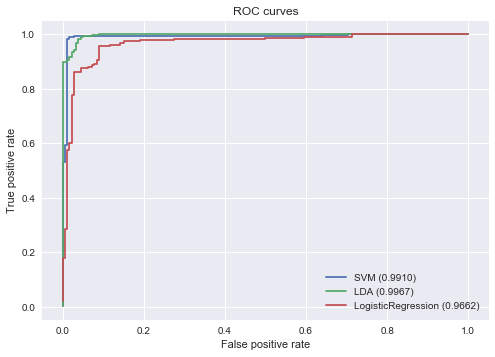

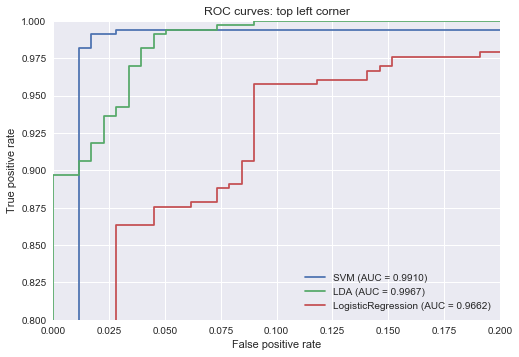

In [12]:
plt.figure(1)
plt.clf()
for cls,name in zip(res,["SVM","LDA","LogisticRegression"]):
    prob = cls.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test, prob[:,1])
    scr = auc(fpr,tpr)
    plt.plot(fpr, tpr,label= name+" ({:1.4f})".format(scr))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='best')
plt.title('ROC curves')
plt.show()
# plt.savefig("../out/clsROC.png")

plt.figure(2)
plt.clf()
plt.xlim(0,.2)
plt.ylim(0.8,1)
for cls,name in zip(res,["SVM","LDA","LogisticRegression"]):
    prob = cls.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test, prob[:,1])
    scr = auc(fpr,tpr)
    plt.plot(fpr, tpr,label= name+" (AUC = {:1.4f})".format(scr))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='best')
plt.title('ROC curves: top left corner')
plt.show()
# plt.savefig("../out/clsROCcrn.png")

In [ ]:
for i in res:
    print(str(i[0])+","+str(i[1]))

In [84]:
isc, 0.93965517241379315, 0.88819875776397517
rnd, 0.93452380952380953, 0.80346820809248554
tt, 0.95795795795795791, 0.93142857142857138
glm, 0.93314763231197773, 0.87248322147651003

NameError: name 'isc' is not defined

In [160]:
?auc

In [16]:
list(zip(y_pred,y_test))

[(False, False),
 (True, True),
 (False, False),
 (True, True),
 (True, True),
 (True, True),
 (True, True),
 (False, False),
 (True, True),
 (False, True),
 (True, True),
 (False, False),
 (True, True),
 (True, True),
 (True, True),
 (False, False),
 (True, True),
 (False, False),
 (True, False),
 (True, True),
 (True, True),
 (False, False),
 (True, True),
 (True, True),
 (False, False),
 (True, True),
 (True, True),
 (True, True),
 (True, True),
 (True, True),
 (False, False),
 (True, True),
 (True, True),
 (True, True),
 (True, True),
 (False, False),
 (True, True),
 (True, True),
 (False, False),
 (True, True),
 (False, False),
 (True, True),
 (True, True),
 (True, True),
 (True, True),
 (True, True),
 (False, False),
 (True, True),
 (True, True),
 (False, False),
 (True, True),
 (True, True),
 (True, True),
 (True, True),
 (True, True),
 (True, True),
 (True, True),
 (False, False),
 (True, True),
 (True, True),
 (True, True),
 (True, True),
 (True, True),
 (True, True),
 (True, 

In [10]:
f(x) = lambda x: if x : "V" else: "S" 
fpr, tpr, l = roc_curve(map(y_test), y_pred)

array([ 0.       ,  0.1547619,  1.       ])

In [48]:
             precision    recall  f1-score   support

      False       0.78      0.83      0.80       168
       True       0.91      0.89      0.90       341

avg / total       0.87      0.87      0.87       509

SyntaxError: invalid syntax (<ipython-input-48-27f1d16a5f92>, line 1)

In [ ]:
best
    precision    recall  f1-score   support

      False       0.88      0.92      0.90       153
       True       0.97      0.94      0.95       356

avg / total       0.94      0.94      0.94       509

In [27]:
t-test:

precision    recall  f1-score   support

      False       0.93      0.88      0.91       173
       True       0.94      0.96      0.95       335

avg / total       0.94      0.94      0.94       508


Automatically created module for IPython interactive environment
